In [9]:
import gym
import numpy as np
import random
import datetime
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
# todo : CartPole-v0


"""
#! ghi chú về bài toán

    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    *Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    *Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    *Reward:
        Reward is 1 for every step taken, including the termination step
    *Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    *Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.


"""

In [4]:
def save_weight(dirfile,weight):
    return np.save(dirfile,weight)

def load_weight(dirfile):
    return np.load(dirfile)

In [42]:

def create_Qtable(state_space, action_space, bins_size = 30):
    
    bins = np.array([
        np.linspace(-4.8,4.8, num=bins_size), # Cart Position : -4.8 -> 4.8
        np.linspace(-10,10, num=bins_size), # Cart Velocity : -Inf -> Inf
        np.linspace(-0.418,0.418, num=bins_size), # Pole Angle :-0.418 rad (-24 deg) -> 0.418 rad (24 deg)
        np.linspace(-10,10, num=bins_size), # Pole Angular Velocity : -Inf -> Inf
    
    ])
    #print(bins.shape)

    q_table = np.random.uniform(low=-1,high=1,size=([bins_size] * state_space + [action_space]))
    # size = [30,30,30,30,2]
    
    return q_table, bins

def create_bins(state_space, action_space, bins_size = 30):
    bins = np.array([
        np.linspace(-4.8,4.8, num=bins_size), # Cart Position : -4.8 -> 4.8
        np.linspace(-10,10, num=bins_size), # Cart Velocity : -Inf -> Inf
        np.linspace(-0.418,0.418, num=bins_size), # Pole Angle :-0.418 rad (-24 deg) -> 0.418 rad (24 deg)
        np.linspace(-10,10, num=bins_size), # Pole Angular Velocity : -Inf -> Inf
    
    ])

    return bins

def discrete(state, bins): # find index of state in linespace
    #? index = discrete([4.8,10,0.418,10],bins=bins) # how to use

    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return index

In [6]:

def get_next_action(q_table,state_current,bins,epsilon):
    
    index = discrete(state_current,bins)
    #print('index in table ',index,'value',q_table[index[0]][index[1]][index[2]][index[3]])
    
    if(np.random.random() <= epsilon): # chose from table
        action = np.argmax( q_table[index[0]][index[1]][index[2]][index[3]] )
        q_value = q_table[index[0]][index[1]][index[2]][index[3]][action]
        return action, q_value, index
    else: # chose random
        action = random.randint(0,1)
        q_value = q_table[index[0]][index[1]][index[2]][index[3]][action]
        return action, q_value, index


In [7]:

def run_game_to_create_weight(env,k_game,episode, q_table,bins, epsilon,discount_factor,learning_rate):
    
    

    for k in range(k_game):
        #? observation = state_current
        observation = env.reset()
        sum_reward = 0
        #print("k_game = ", k, end=' -> ')
        

        for e in range(episode):
            #env.render() # show image
            
            # chose action
            action_should_do, q_value, index = get_next_action(q_table,observation,bins,epsilon)
            #print('action : ',action_should_do,"~~",str(action[action_should_do]))
            
            # perform action
            observation, reward, done, info = env.step(action_should_do)
            
            # measure reward 
            sum_reward += 1
            
            index_new = discrete(observation,bins)
            temp = reward + (discount_factor * np.max(q_table[index_new[0]][index_new[1]][index_new[2]][index_new[3]])) - q_value 
            new_q_value = q_value + (learning_rate * temp)
            
            # update Q_table
            q_table[index[0]][index[1]][index[2]][index[3]][action_should_do] = new_q_value

            if done:
                #print("Episode length = ",sum_reward)
                break


        


    env.close()

    return q_table

def run_game(env,k_game,episode, q_table,bins):
    arr_reward = []
    for k in range(k_game):
        #? observation = state_current
        observation = env.reset()
        sum_reward = 0
        #print("k_game = ", k, end=' -> ')

        for e in range(episode):
            #env.render()
            # get action
            action_should_do, q_value, index = get_next_action(q_table,observation,bins,epsilon=1)
            
            # perform action
            observation, reward, done, info = env.step(action_should_do)
            
            # measure reward
            sum_reward += reward

            if done:
                #print("Episode length = ", sum_reward)
                arr_reward.append(sum_reward)
                break

    
    return arr_reward

In [11]:

def main_v001():
    # *dir file weight 
    dirfile = 'weight\CartPole-v0_Qtable_v001.npy'

    # *rate
    epsilon = 0.9
    discount_factor = 0.9
    learning_rate = 0.9

    # *create env
    env = gym.make('CartPole-v0')

    # * action, reward, q_table(s,a)
    action = ['left', 'right']
    reward = 1

    state_space = 4
    action_space = 2
    bins_size = 30 # state can infinity, so we collap them to bins

    q_table,bins = create_Qtable(state_space,action_space,bins_size)
    print("q_table",q_table.shape,",bins",bins.shape)

    
    '''
    # TODO : calculate weight and save
    k_game = 300
    print('\nrun n game ')
    q_table = run_game_to_create_weight(env=env,
                                        k_game=1000,
                                        episode=200,
                                        q_table=q_table,
                                        bins=bins,
                                        epsilon=epsilon,
                                        discount_factor=discount_factor,
                                        learning_rate=learning_rate)
    print("Done !\n")
    
    save_weight(dirfile,q_table)
    print('save weight to ',dirfile)
    '''

    # TODO : load weight and run
    q_table = load_weight(dirfile)
    print('q_table ',q_table.shape)

    # k_game>100 => if 100 game have average episode ~~ 195  
    k_game = 10
    arr_reward = run_game(env=env,
                            k_game=k_game,
                            episode=200,
                            q_table=q_table,
                            bins=bins)
    arr_reward = np.array(arr_reward)
    print('Average ',k_game,'k_game = ',np.average( arr_reward ) )

    arr_reward_Solved = np.delete(arr_reward,np.where(arr_reward<195))
    print('Average ',arr_reward_Solved.shape[0],'k_game_Solved = ',np.average( arr_reward_Solved ) )
    
    #*Average  300 k_game =  144.57666666666665
    #*Average  78 k_game_Solved =  199.66666666666666
    #*Average  2000 k_game =  140.656
    #*Average  501 k_game_Solved =  199.71656686626747


In [19]:
main_v001()

q_table (30, 30, 30, 30, 2) ,bins (4, 30)
q_table  (30, 30, 30, 30, 2)
Average  10 k_game =  116.1
Average  2 k_game_Solved =  200.0


# 2 bieu thi tren bieu do va danh gia

In [ ]:

def create_weight(k_game,epsilon,discount_factor,learning_rate):

    # *create env
    env = gym.make('CartPole-v0')

    state_space = 4
    action_space = 2
    bins_size = 30 # state can infinity, so we collap them to bins

    q_table,bins = create_Qtable(state_space,action_space,bins_size)
    #print("q_table",q_table.shape,",bins",bins.shape)

    
    # TODO : calculate weight and save
    #k_game = 1000
    episode = 200
    #print('\nrun n game ')
    q_table = run_game_to_create_weight(env=env,
                        k_game=k_game,
                        episode=episode,
                        q_table=q_table,
                        bins=bins,
                        epsilon=epsilon,
                        discount_factor=discount_factor,
                        learning_rate=learning_rate)
    #print("Done !\n")
    
    # *dir file weight 
    namefile = 'CartPole-v0_Qtable'+'-epsilon_{epsilon:.2f}'+'-discount_factor_{discount_factor:.2f}'+'-learning_rate_{learning_rate:.2f}'+'.npy'
    namefile = namefile.format(epsilon=epsilon,discount_factor=discount_factor,learning_rate=learning_rate)
    print(namefile)
    np.save("weight/"+namefile,q_table)


In [ ]:
    
def create_multiple_weight(min_rate,max_rate):
    # * k_game
    k_game = 1000

    # *rate
    epsilon_min, epsilon_max = min_rate,max_rate
    discount_factor_min, discount_factor_max = min_rate,max_rate
    learning_rate_min, learning_rate_max = min_rate,max_rate
    step = 0.02
    
    # TODO : create multiple rate to summary what is the best chose rate

    for epsilon in np.arange(epsilon_min,epsilon_max,step):
        for discount_factor in np.arange(discount_factor_min,discount_factor_max,step):
            for learning_rate in np.arange(learning_rate_min,learning_rate_max,step):
                t1 = datetime.datetime.now()
                create_weight(k_game,epsilon,discount_factor,learning_rate)
                t2 = datetime.datetime.now()
                print("delta time = ", t2-t1)


In [94]:

def create_game(dirfile,k_game, epsilon,discount_factor,learning_rate):
    # *create env
    env = gym.make('CartPole-v0')

    state_space = 4
    action_space = 2
    bins_size = 30 # state can infinity, so we collap them to bins

    bins = create_bins(state_space,action_space,bins_size)
    #print("q_table",q_table.shape,",bins",bins.shape)

    # TODO : load weight and run
    q_table = load_weight(dirfile)
    #print('q_table ',q_table.shape)

    # k_game>100 => if 100 game have average episode ~~ 195  
    arr_reward = run_game(env=env,
                            k_game=k_game,
                            episode=200,
                            q_table=q_table,
                            bins=bins)
    arr_reward = np.array(arr_reward)
    avg_reward = np.average( arr_reward )
    #print('Average ',k_game,'k_game = ',avg_reward )

    arr_reward_Solved = np.delete(arr_reward,np.where(arr_reward<195))
    avg_reward_over_195 = 0
    if(len(arr_reward_Solved) != 0):
        avg_reward_over_195 = np.average( arr_reward_Solved )
    #print('Average ',arr_reward_Solved.shape[0],'k_game_Solved = ',avg_reward_over_195 )
    
    return arr_reward.shape[0],avg_reward,arr_reward_Solved.shape[0],avg_reward_over_195

def create_multiple_reward(dirfile,namefile,k_game):
    #dir = 'weight/'
    rewards = np.array([[0,0,0,0,0,0,0]])   
    i = 0
    files = Path(dirfile).glob(namefile)
    for file in files:
        print(file)
        temp = str(file).replace('.npy','')
        temp = temp.split('epsilon')[1]

        epsilon = float(temp.split('discount_factor')[0].replace('-','').replace('_',''))
        discount_factor = float(temp.split('discount_factor')[1].split('learning_rate')[0].replace('-','').replace('_',''))
        learning_rate = float(temp.split('learning_rate')[1].replace('-','').replace('_',''))
        
        
        n_game1,avg_reward, n_game2,avg_reward_over_195 = create_game(file,k_game,epsilon,discount_factor,learning_rate)
        temp = np.array([[epsilon,discount_factor,learning_rate,n_game1,avg_reward,n_game2,avg_reward_over_195]])
        rewards = np.append(rewards,temp,axis=0)
        
        

    rewards = rewards[1:]
    return rewards


In [95]:
# 1 : 0.8 , 0.86
# 2 : 0.86 , 0.9
# 3 : 0.9 , 0.96
# 4 : 0.96 , 0.99
# 5 : 0.81 , 0.87
# 6 : 0.87 , 0.91
# 7 : 0.91 , 0.97
# 8 : 0.97 , 1.0
#min_rate, max_rate = 0.97 , 1.0
#create_multiple_weight(min_rate,max_rate)
# ! Done !

In [ ]:
#create DataFrame: k_game = 1000
#    epsilon discount_factor learning_rate avg_reward avg_reward_over_195
#1   0.8     0.8             0.8                ?              ?
#2   0.8     0.8             0.81               ?              ?
#3   0.8     0.8             0.82               ?              ?

dirfile = 'weight/'
namefile = 'CartPole-v0_Qtable-epsilon*.npy'
k_game = 500

rewards = create_multiple_reward(dirfile,namefile,k_game)
#print(rewards)

summary = pd.DataFrame(rewards)
summary = summary.set_axis(['epsilon', 'discount_factor', 'learning_rate', 'k_game','avg_reward', 'k_game_195','avg_reward_over_195'],axis=1)
print(summary)
summary.to_csv('summary.csv',index=False)

# 3 Visualization 

In [90]:
summary = pd.read_csv('summary.csv')
summary = summary.sort_values(by=['epsilon','discount_factor','learning_rate','avg_reward','k_game_195','avg_reward_over_195'])
summary
# summary.sort_values(by=['avg_reward'],ascending=Fasle)

,epsilon,discount_factor,learning_rate,k_game,avg_reward,k_game_195,avg_reward_over_195
0,0.80,0.80,0.80,500.0,110.588,0.0,0.00000
1,0.80,0.80,0.82,500.0,55.176,32.0,199.84375
2,0.80,0.80,0.84,500.0,69.540,0.0,0.00000
3,0.80,0.82,0.80,500.0,52.272,0.0,0.00000
4,0.80,0.82,0.82,500.0,54.540,0.0,0.00000
...,...,...,...,...,...,...,...
171,0.98,0.98,0.98,500.0,47.474,0.0,0.00000
172,0.99,0.97,0.97,500.0,24.616,0.0,0.00000
173,0.99,0.97,0.99,500.0,16.188,0.0,0.00000
174,0.99,0.99,0.97,500.0,50.626,0.0,0.00000


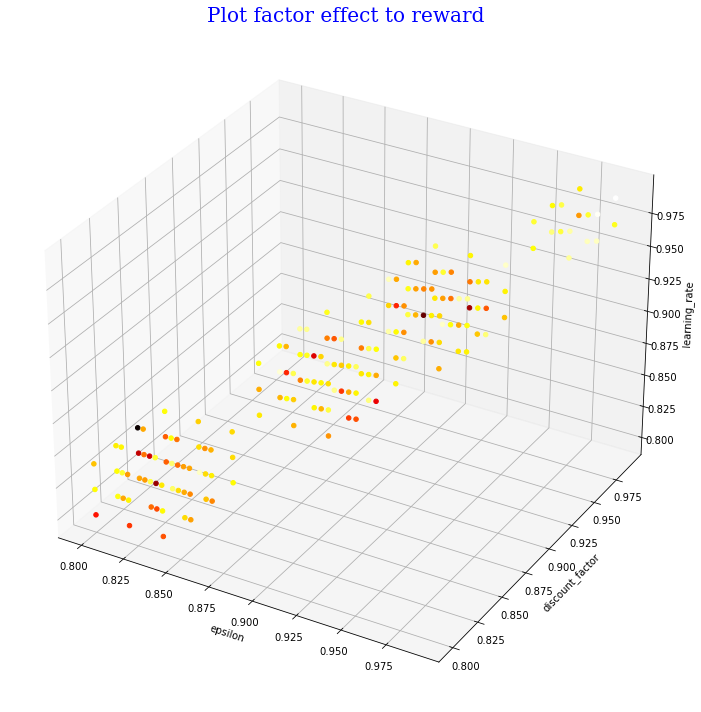

In [71]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = summary['epsilon']
y = summary['discount_factor']
z = summary['learning_rate']
#c = scaler0to100.transform( summary['avg_reward'] )
c = summary['avg_reward']
s = summary['k_game_195']
img = ax.scatter(x, y, z, c=c, cmap='hot_r', alpha=1)

ax.set_xlabel('epsilon')
ax.set_ylabel('discount_factor')
ax.set_zlabel('learning_rate')

plt.title("Plot factor effect to reward",fontdict = font1)

plt.show()


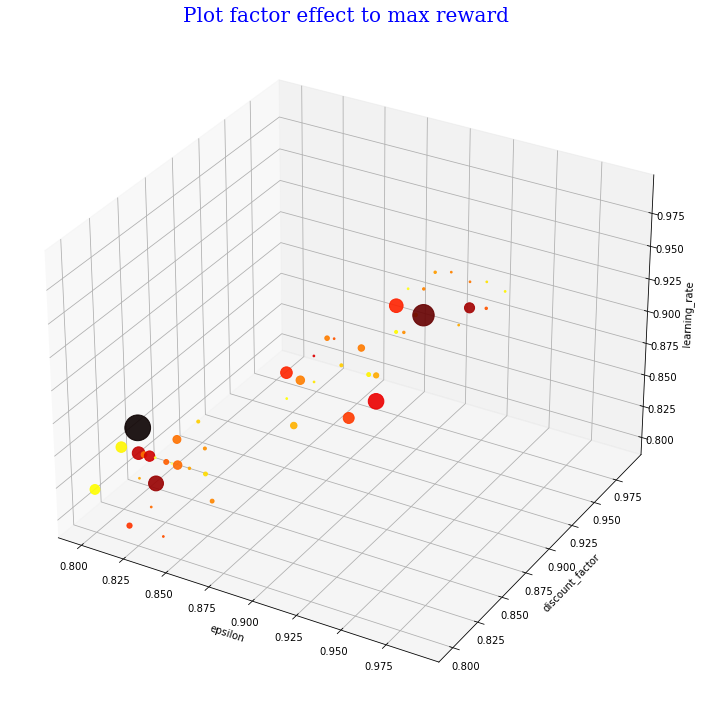

In [91]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = summary['epsilon']
y = summary['discount_factor']
z = summary['learning_rate']
c = summary['avg_reward']
s = summary['k_game_195']

img = ax.scatter(x, y, z, c=c,s= s*3 , cmap='hot_r', alpha=0.9)

ax.set_xlabel('epsilon')
ax.set_ylabel('discount_factor')
ax.set_zlabel('learning_rate')

plt.title("Plot factor effect to max reward",fontdict = font1)

plt.show()


In [89]:
s2 = summary.sort_values(by=['avg_reward'],ascending=False).drop(columns=['avg_reward_over_195'])
print('factor with max reward :\n',s2.head(3))

factor with max reward :
      epsilon  discount_factor  learning_rate  k_game  avg_reward  k_game_195
8       0.80             0.84           0.84   500.0     173.118       221.0
128     0.92             0.92           0.92   500.0     151.300       153.0
28      0.83             0.81           0.83   500.0     139.224        74.0
